# Modelling Molecules with Brownian Motion

## Brandon Le

Brownian motion is a real-valued stochastic process $\{B(t):t\geq 0\}$ (think of collection of random variables ordered by time) with the following properties:

(i) $B(0) = \vec{0}$ (can loosen this definition to have $B(0) = \vec{x} \in \mathbb{R}^n$)

(ii) Independent increments, i.e. for all times $0 \leq t_1 \leq t_2 \leq \dots \leq t_n, B(t_n) - B(t_{n-1}), \dots, B(t_2) - B(t_1)$ are independent random variables.

(iii) For all $t > 0$ and $h > 0, B(t+h) - B(t)$ is normally distributed with mean $\vec{0}$ and covariance matrix $hI$.

(iv) the mapping $t \rightarrow B(t)$ is continuous almost everywhere.

We're modeling Brownian motion discretely; assuming the timesteps are equally sized, we're really modeling a summation of independent normally distributed displacements by property (ii) and (iii). Given an arbitrary particle starting at $\vec{x}$, we can approximated its motion by:

$$B(0) \sim \vec{x}$$
$$B(1) \sim B(0) + N(0,\sqrt{h})$$
$$B(2) \sim B(1) + N(0,\sqrt{h})$$
$$ \cdots $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random

Due to the radial symmetry of the project, we'll be working with polar coordinates.

Given two points $(\theta_1, r_1)$ and $(\theta_2, r_2)$, we have for the sum of the points $(\theta, r)$:

$$\theta = \theta_1 + arctan2(r_2sin(\theta_2 - \theta_1),r_1 + r_2cos(\theta_2 - \theta_1))$$

$$ r = \sqrt{r_1^2 + r_2^2 + 2r_1r_2cos(\theta_1 - \theta_2)}$$

In [2]:
def add_vectors(a,b):
    #a and b are matrices where each row is a point in polar coordinates (theta,r)
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    ang_a, ang_b = a[:,0], b[:,0]
    len_a, len_b = a[:,1], b[:,1]
    c = a.copy()
    angle_sum = ang_a + np.arctan2(len_b*np.sin(ang_b - ang_a), len_a + len_b*np.cos(ang_b - ang_a))
    length_sum = np.sqrt(len_a**2 + len_b**2 + 2*len_a*len_b*np.cos(ang_a - ang_b)) 
    c[:,0], c[:,1] = angle_sum, length_sum
    return c

def subtract_vectors(a,b):
    #a-b = a + (-b), where -b has the same radius but rotated 180deg/pi radians
    c = b.copy()
    c[:,0] = b[:,0] + np.pi
    return add_vectors(a,c)

def gen_normal(points, length = 1):
    #points is a matrix of points, each row is point (theta,r)
    #adds a vector in a random direction to each of the points, simulating movement
    update = np.zeros(np.shape(points))
    angles = np.random.uniform(0, 2*np.pi, size = (points.shape[0],1))
    #choose either fixed movement or normally dist. movement (they both converge to brownian motion distribution)
    lengths = np.tile(length, (points.shape[0],1))
    #lengths = np.absolute(np.random.normal(0, length, size = (points.shape[0],1)))
    b = np.concatenate(((angles,lengths)), axis = 1)
    update = add_vectors(points, b)
    return update

def distance_matrix(points):
    #creates a matrix whose i,jth entry is the distance between point i and point j
    angles = points[:,0]
    lengths = points[:,1]
    angles_x = np.tile(angles, [len(points),1])
    angles_y = angles_x.T
    lengths_x = np.tile(lengths, [len(points),1])
    lengths_y = lengths_x.T
    return np.sqrt(lengths_x**2 + lengths_y**2 - 2*lengths_x*lengths_y*np.cos(angles_x - angles_y))

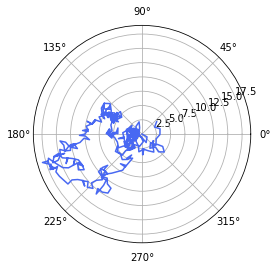

In [3]:
#brownian motion of a particle
start = np.zeros((1,2))
m = 300 #iterations
storage = [0]*m
storage[0] = start

for i in range(m-1):
    storage[i+1] = gen_normal(storage[i])
    
for j in range(start.shape[0]):
    theta,r = [e[j,0] for e in storage],[e[j,1] for e in storage]
    plt.polar(theta,r,c=np.random.rand(3,))
plt.show()

<IPython.core.display.Javascript object>


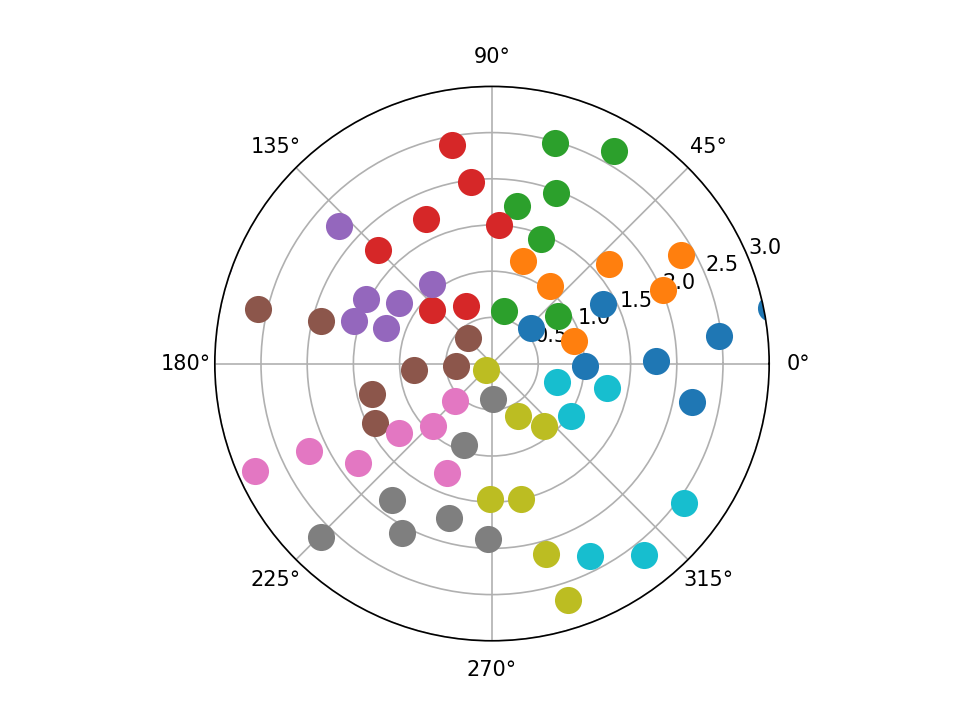

In [4]:
#remove below line if running as .py file
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(polar = True)
ax.set_ylim(0,3)

steps = 200
particles = 70  #this has to be a multiple of 10 for animation to work
jitter = .05
#jitter = .1

#assume the particles have radius r1 (will modify to include 2 types of particles, each with rad r1,r2)
r1 = 0.13
r2 = 0.13

#generate points, they shouldn't overlap for realistic collisions
#start = np.zeros((particles,2))
#start = np.concatenate((np.random.uniform(0, 2*np.pi,(particles,1)), abs(np.random.normal(0,1,(particles,1)))), axis = 1)
grid_len = np.linspace(0.5, 2.5, num=round(particles/10))
grid_ang = np.linspace(0,np.pi*7/4, num = 10)
len_rep = np.array([np.repeat(grid_len,len(grid_ang))])
ang_rep = np.array([np.tile(grid_ang, len(grid_len))])
start = np.concatenate((ang_rep,len_rep), axis = 0).T

#creates list for animation, this and for loop not necessary when finalized function only performs gen_normal() once
#will need to create the finalized function after presentation
storage = [0]*steps
storage[0] = start

for i in range(steps-1):
    storage[i+1] = gen_normal(storage[i], jitter)
    dist = distance_matrix(storage[i+1])
    #find position entries where collision occurs
    crossed = np.where(dist < r1 + r2)
    #look only at top-right entries due to symmetry of dist. matrix
    alpha = crossed[0][crossed[0] < crossed[1]]
    beta = crossed[1][crossed[0] < crossed[1]]
    #want to find w = u - v, where w is displacement, u is current position and v is prev. pos.
    #when collision occurs we want to move opposite of w, with some wiggle room for variance (aka moving backwards)
    #note u - v = u+(-v), where -v is v after adding 180deg/pi to theta
    scalar = 1.0
    while len(alpha) != 0 and scalar < 10:
        w_a = subtract_vectors(storage[i+1][alpha], storage[i][alpha])
        w_b = subtract_vectors(storage[i+1][beta], storage[i][beta])
        w_a[:,0] += np.pi + np.random.uniform(0, 2*np.pi/4)
        w_b[:,0] += np.pi + np.random.uniform(0, 2*np.pi/4)
        #now let's move our move our particles back
        orig_a = storage[i+1][alpha].copy()
        orig_b = storage[i+1][beta].copy()
        #move particles back proportionally to their size, bigger particle moves less
        storage[i+1][alpha] = add_vectors(orig_a, w_a)
        storage[i+1][beta] = add_vectors(orig_b, w_b)
        #updates everything and runs loop until after no more intersections or after scalar tries
        dist = distance_matrix(storage[i+1])
        crossed = np.where(dist < r1 + r2)
        alpha = crossed[0][crossed[0] < crossed[1]]
        beta = crossed[1][crossed[0] < crossed[1]]
        scalar = scalar + 1
        

# creates the first plot in animation
pnt = ax.plot(np.zeros((1,particles)), np.zeros((1,particles)), 'o', markersize = 12)

# function that updates first plot along the animation
def update_point(n, storage, pnt):
    for point_i, index in zip(pnt,range(particles)):
        point_i.set_data((storage[n][index,0], storage[n][index,1]))
    return pnt

ani = animation.FuncAnimation(fig, update_point, steps - 1, fargs=(storage, pnt), interval = 100)

plt.show()